In [1]:
import struct
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from utils.colmap_utils import (read_cameras_binary,
                                read_points3D_binary, 
                                read_images_binary, 
                                create_transforms_json)
from utils.plot_utils import visualize_point_cloud
from glob import glob
import cv2
from concurrent.futures import ThreadPoolExecutor

from scipy.spatial import KDTree

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cameras_file = "data/sparse/0/cameras.bin"
cameras_data = read_cameras_binary(cameras_file)

if cameras_data:
    first_camera_id = list(cameras_data.keys())[0]
    print(f"Camera {first_camera_id} info:")
    print(cameras_data[first_camera_id])

Camera 1 info:
{'model_id': 4, 'width': 960, 'height': 540, 'params': [556.9740875009339, 553.8176655260585, 480.0, 270.0, 0.00527160502148155, -0.007437133878853077, 0.0032169834001347657, 0.013468197350392126]}


Loaded 56042 points


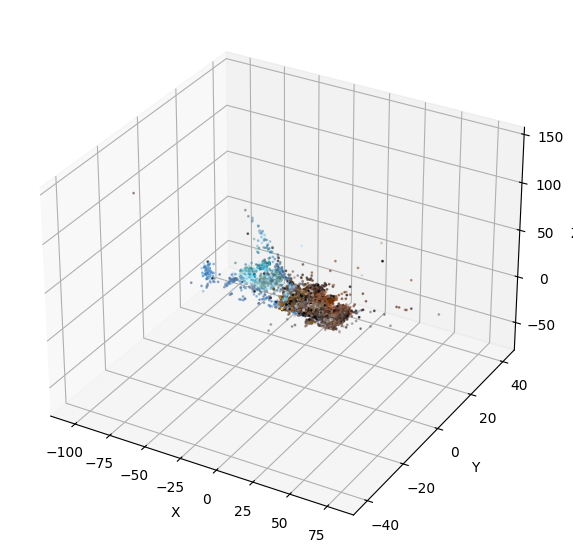

In [3]:
# points3D_file = "data/dense/dense_points3D.bin"
# not noticing significant difference between sparse / dense (from original gaussian-splatting repository)
points3D_file = "data/sparse/0/points3D.bin"
points3D_data = read_points3D_binary(points3D_file)

points = np.array([v["xyz"] for v in points3D_data.values()])
colors = np.array([v["rgb"] / 255.0 for v in points3D_data.values()])

print(f"Loaded {len(points)} points")

visualize_point_cloud(points, colors)

In [4]:


class GaussianSplatting:
    def __init__(self, images_path='data/images', points_path='data/sparse/0/points3D.bin'):
        self.M_points = self.get_sfm_points(points_path)
        # self.images, self.height, self.width = self.get_images(images_path)
    
    def get_images(self, images_path):
        images_data = sorted(glob(images_path + '/*.png'))
        with ThreadPoolExecutor() as executor: # faster loading
            images = list(executor.map(cv2.imread, images_data))
        height, width, _ = images[0].shape
        return images, height, width

    def get_sfm_points(self, points_path):
        """
        𝑀 ← SfM Points ⊲ Positions
        """
        points3D_data = read_points3D_binary(points_path)
        points = np.array([v["xyz"] for v in points3D_data.values()])
        colors = np.array([v["rgb"] / 255.0 for v in points3D_data.values()])
        return points, colors
    
    def init_attributes(self):
        """
        𝑆,𝐶, 𝐴 ← InitAttributes() ⊲ Covariances, Colors, Opacities

        https://medium.com/@yianyao1994/gaussian-splatting-part-2-representation-and-initialization-c0a036adf16e
        
        Center: Set to the point cloud locations from SfM.
        Scaling factor: Initialized as isotropic, using the mean distance to the 3-nearest neighbors.
        Rotation: No initial rotation is applied.
        Opacity: Set to 0.1.
        Spherical Harmonics (SH): Inherited from the color information in the point cloud.

        """
        # 3D covariance matrix Σ



model = GaussianSplatting()


In [5]:
def init_gaussian_covariance(points):
    """
    Explanation
    Sec 4: 
        Directly optimizing covariance matrix Σ can lead to non positive non semi-definite covariance matrices.
        Instead, we factorize Σ = 𝑅𝑆𝑆^𝑇𝑅^𝑇 [7dof], allowing anisotropic covariance and valid covariance matrices.
        For independent optimization, we store S: 3D vector for scaling and quaternion q (normalize to get valid unit quaternion)

        Convert these splats to pixel space
            W viewing transformation or extrinsics
            J Jacobian projective transformation or intrinsics
            Σ' = JW Σ W^TJ^T

    Initialization
    Sec 5.1
        "We estimate the initial covariance matrix as an isotropic Gaussian 
        with axes equal to the mean of the distance to the closest three points."

    Gradient Computation
    Appendix A
        dΣ' / ds = dΣ'/dΣ * dΣ / ds
        dΣ' / dq = dΣ'/dΣ * dΣ / dq

    Simplify Σ' = JW Σ W^TJ^T using U=JW and Σ' being (symmetric) upper left 2x2
    Σ' = U Σ U^T
    """
    # non gradient implementation for now
    # Have to revist complexity of KDTree
    kdtree = KDTree(points)
    distances, _ = kdtree.query(points, k=4)  # k=4 includes the point itself
    
    nearest_distances = distances[:, 1:4]
    mean_distances = nearest_distances.mean(axis=1)
    
    initial_sigma = np.eye(3) * mean_distances[:, np.newaxis, np.newaxis]

    return initial_sigma


In [6]:
initial_sigma = init_gaussian_covariance(points)

In [7]:
n_std = 2

def create_ellipsoids(covariance, n_std=2, res=10):
    # Generate unit sphere coordinates once (moved outside the loop)
    u = np.linspace(0, 2 * np.pi, res)
    v = np.linspace(0, np.pi, res)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    sphere = np.stack((x, y, z), axis=-1)  # Shape: (100, 100, 3)

    # Vectorized operations
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)  # Shape: (N, 3), (N, 3, 3)
    radii = n_std * np.sqrt(eigenvalues)  # Shape: (N, 3)

    # Reshape for broadcasting
    sphere_expanded = sphere[np.newaxis, ...]  # Shape: (1, 100, 100, 3)
    radii_expanded = radii[:, np.newaxis, np.newaxis, :]  # Shape: (N, 1, 1, 3)

    # Scale the sphere points
    scaled_points = sphere_expanded * radii_expanded  # Shape: (N, 100, 100, 3)

    # Reshape for matrix multiplication
    scaled_points_reshaped = scaled_points.reshape(len(covariance), -1, 3)  # Shape: (N, 10000, 3)

    # Apply rotation using eigenvectors
    # einsum performs the matrix multiplication for all points at once
    ellipsoids = np.einsum('nij,nkj->nki', eigenvectors, scaled_points_reshaped)

    # Reshape back to original shape
    ellipsoids = ellipsoids.reshape(len(covariance), res, res, 3)

    return ellipsoids